In [36]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Deep Neural Networks 

## Working with Tensorflow 
- One hidden layer
- Make_moon

In [37]:
# Lets import some libraries
import os

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

from sklearn import datasets

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

from sklearn.preprocessing import StandardScaler

import tensorflow as tf

%matplotlib inline

In [38]:
# Some basic parameters

inpDir = './' # location where input data is stored
outDir = './' # location to store outputs
modelDir = './'
subDir = 'make_moon'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production

np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results
tf.random.set_seed(RANDOM_STATE) # setting for Tensorflow as well


EPOCHS = 100 # number of epochs
ALPHA = 0.01 # learning rate

#BATCH_SIZE = 256 
NUM_SAMPLE = 1280
NOISE = 0.2
TEST_SIZE = 0.2

# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (15,15),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

CMAP = plt.cm.brg

plt.rcParams.update(params) # update rcParams

### Settings so that Tensorflow can not Hog all the GPU memory

In [39]:
physical_devices = tf.config.list_physical_devices('GPU') 

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Load make_moon

In [40]:
X, y = datasets.make_moons(n_samples=NUM_SAMPLE, noise=NOISE, random_state=RANDOM_STATE)
X.shape, y.shape

((1280, 2), (1280,))

In [41]:
#  Split the data in training and test sets to measure performance of the model.
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=TEST_SIZE,
                                                    stratify=y,
                                                    random_state=RANDOM_STATE )

print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1024, 2) (1024,) (256, 2) (256,)


In [42]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)

X_test = sc.transform(X_test)

In [43]:
X_train.shape

(1024, 2)

## Prepare model

Build the `tf.keras.Sequential` model by stacking layers from `tf.keras.layers.Dense`. Activations can be given as string or from `tf.keras.activations.tanh` 

In [44]:
# Define Model Calling class Sequential and pass all layers as a list
model = tf.keras.Sequential([ 
                             
    tf.keras.layers.Dense(4, activation='tanh'),
    
    tf.keras.layers.Dense(2)
])

## Reference
<p style="font-family: Arial; font-size:1.2em;color:black;">
Details of <a href = "https://www.tensorflow.org/api_docs/python/tf/keras/Sequential">Sequential Model</a>. Sequential provides training and predict features on this model.
</p>

### Functional API

<p style="font-family: Arial; font-size:1.2em;color:black;">You can also instantiate a Model with the <strong>"Functional API"</strong>, where you start from Input, you chain layer calls to specify the model's forward pass, and finally you create your model from inputs and outputs:

>import tensorflow as tf

>inputs = tf.keras.Input(shape=(2,))
    
>x = tf.keras.layers.Dense(4, activation=tf.nn.relu)(inputs)

>outputs = tf.keras.layers.Dense(2, activation=tf.nn.softmax)(x)

>model = tf.keras.Model(inputs=inputs, outputs=outputs)

    
<p style="font-family: Arial; font-size:1.2em;color:black;">You can also extend the model class, if love to live by sword!!
</p>

<p style="font-family: Arial; font-size:1.2em;color:black;">
    For each example the model returns a vector of "logits" or "log-odds" scores, one for each class.
</p>

<p style="font-family: Arial; font-size:1.2em;color:black;">
    <b>Unit Test</b>: Predict using untrained model.
</p>

In [45]:
y_pred= model(X_train[:1])
y_pred

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-1.0997471 , -0.51884216]], dtype=float32)>

In [46]:
tf.nn.softmax(y_pred)

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.3587244, 0.6412756]], dtype=float32)>

The `tf.nn.softmax` function converts these logits to "probabilities" for each class: 

In [47]:
'''
Number of parameters:
    layer 1 : 2*4 +4 = 12 
    layer 2 : 4*4 + 2 = 10
We are not locking any layer hence all parameter are trainable    
'''

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (1, 4)                    12        
                                                                 
 dense_5 (Dense)             (1, 2)                    10        
                                                                 
Total params: 22 (88.00 Byte)
Trainable params: 22 (88.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Game Changer

`Softmax` function is prone to two issues: overflow and underflow.

- <b>Overflow</b> occurs when very large numbers are being fed.
- <b>Underflow</b> occurs when very small numbers (near zero) are being fed.

There are work arounds too, but, TF has its own approach.<br>
    
Intuition being that every system (32 / 64 bit precision) has limits in terms of largest or smallest value it can accurately process.

It also leads to the vanishing gradient in exponential functions. As you go higher/lower it  will overflow and the gradient will be `zero` irrespective of actually it being a `non-zero`.

## Lose Function

Our loss function is crossentropy as there are two or more label classes. The labels are provided using one-hot representation. We will use CategoricalCrossentropy loss. 
    
>y_true = [ 0, 2 ] <b>Sparse Representation</b><br>
>y_true = [ [1      0    0], [ 0    0   1 ] <b>Dense Representation</b><br>
>y_pred = [ [0.05, 0.95, 0], [0.1, 0.1, 0.8] ]


In case, you have not one-hot-encoded use `losses.SparseCategoricalCrossentropy`. It takes a vector of logits and a `True` index and returns a scalar loss for each example.

In [48]:
import sys

sys.float_info.max

1.7976931348623157e+308

In [49]:
sys.float_info.min

2.2250738585072014e-308

In [50]:
np.log(sys.float_info.max)

709.782712893384

In [51]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy ( from_logits = True)

In [52]:
y_train[:1]

array([0], dtype=int64)

In [53]:
loss_fn(y_train[:1], y_pred).numpy()

1.0252008

## Compile model
Using `model.compile`, specify the training configuration such as:
- Loss function to minimize
- Optimizer `'SGD'`
- List of metrics to monitor `'accuracy'`

In [54]:
model.compile(optimizer= 'SGD',
loss= loss_fn,
metrics= ['accuracy'])

## pass model
Call `fit(X, y, validation_data=[X_test, y_test], epochs=EPOCHS)` , which will train the model, and repeatedly iterating over the entire dataset for a given number of `epochs`. Pass some validation for monitoring validation loss and metrics at the end of each epoch.

In [55]:
history=model.fit(X_train, y_train,
          validation_data=[X_test, y_test],
          epochs= EPOCHS
          )

Epoch 1/100
32/32 [==============================] - 1s 9ms/step - loss: 0.7166 - accuracy: 0.5674 - val_loss: 0.6313 - val_accuracy: 0.7344
Epoch 2/100
32/32 [==============================] - 0s 3ms/step - loss: 0.5909 - accuracy: 0.7676 - val_loss: 0.5253 - val_accuracy: 0.8438
Epoch 3/100
20/32 [=================>............] - ETA: 0s - loss: 0.5311 - accuracy: 0.8188

32/32 [==============================] - 0s 5ms/step - loss: 0.5137 - accuracy: 0.8369 - val_loss: 0.4580 - val_accuracy: 0.8789
Epoch 4/100
32/32 [==============================] - 0s 5ms/step - loss: 0.4651 - accuracy: 0.8555 - val_loss: 0.4138 - val_accuracy: 0.8945
Epoch 5/100
32/32 [==============================] - 0s 4ms/step - loss: 0.4334 - accuracy: 0.8633 - val_loss: 0.3833 - val_accuracy: 0.9023
Epoch 6/100
32/32 [==============================] - 0s 4ms/step - loss: 0.4116 - accuracy: 0.8652 - val_loss: 0.3613 - val_accuracy: 0.9062
Epoch 7/100
32/32 [==============================] - 0s 4ms/step - loss: 0.3962 - accuracy: 0.8633 - val_loss: 0.3451 - val_accuracy: 0.9062
Epoch 8/100
32/32 [==============================] - 0s 4ms/step - loss: 0.3847 - accuracy: 0.8633 - val_loss: 0.3324 - val_accuracy: 0.9023
Epoch 9/100
32/32 [==============================] - 0s 3ms/step - loss: 0.3760 - accuracy: 0.8613 - val_loss: 0.3225 - val_accuracy: 0.8945
Epoch 10/100
32/32 [=====

## Evaluate the model
In case we want to separately evaluate this model, we have `evaluate` function.

In [56]:
model.evaluate ( X_test,  y_test, verbose=2)

8/8 - 0s - loss: 0.2393 - accuracy: 0.9102 - 40ms/epoch - 5ms/step


[0.2392815500497818, 0.91015625]

In [57]:
hist_df = pd.DataFrame(history.history)
hist_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.716582,0.567383,0.631271,0.734375
1,0.590908,0.767578,0.525296,0.843750
2,0.513716,0.836914,0.458028,0.878906
3,0.465108,0.855469,0.413839,0.894531
4,0.433394,0.863281,0.383297,0.902344


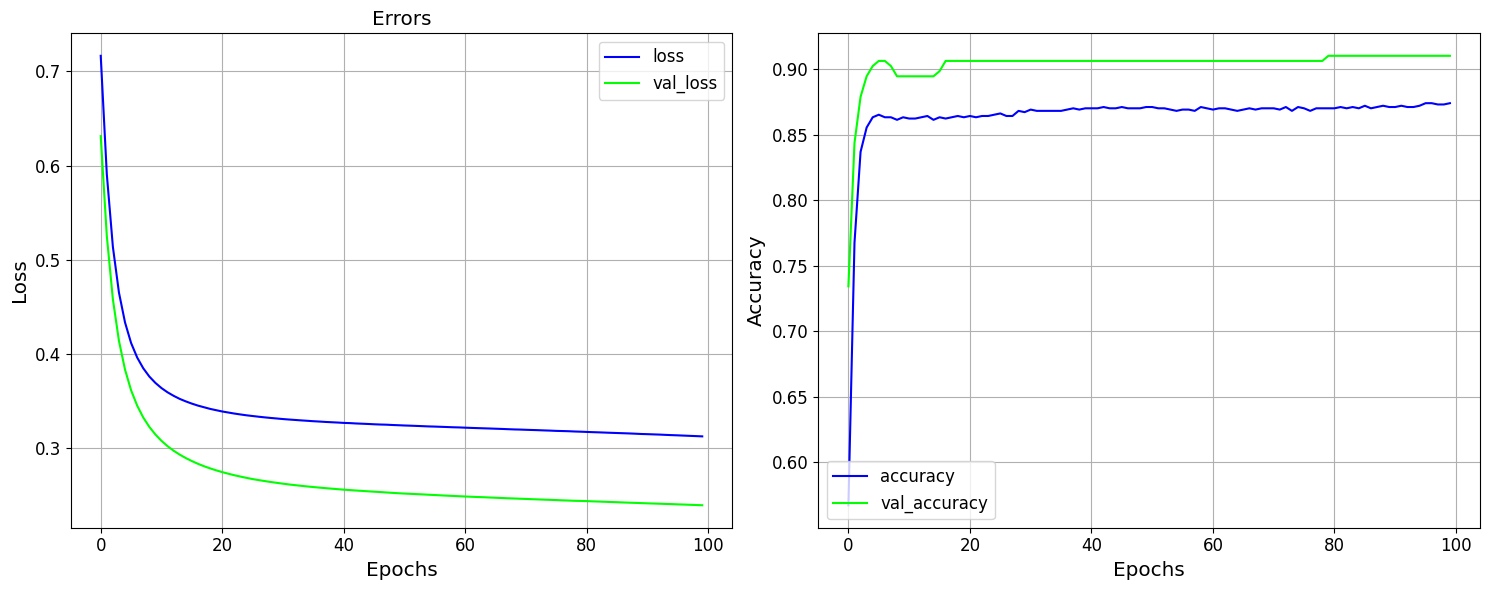

In [58]:
fig, axes = plt.subplots(1,2 , figsize = (15,6))

ax = axes[0]

hist_df.plot(y = ['loss', 'val_loss'], ax = ax, colormap=CMAP)

ax.set_xlabel("Epochs")
ax.set_ylabel('Loss')
ax.set_title('Errors')
ax.grid();
ax = axes[1]

hist_df.plot( y = ['accuracy', 'val_accuracy'], ax = ax, colormap=CMAP)

ax.set_xlabel("Epochs")
ax.set_ylabel('Accuracy')
ax.grid()
ax.legend(loc = 'lower left')

plt.tight_layout()

## Predictions
Build a prediction model using `tf.keras.Sequential` again and add `tf.keras.layers.Softmax` to model.

Make predictions and print classification reports and confusion matrix.

In [60]:
prob_model = tf.keras.Sequential([
    model,
    tf.keras.layers.Softmax()

])

In [61]:
y_pred= prob_model(X_train)

In [62]:
print(classification_report(y_train, np.argmax(y_pred, axis = 1)))

              precision    recall  f1-score   support

           0       0.88      0.87      0.87       512
           1       0.87      0.88      0.87       512

    accuracy                           0.87      1024
   macro avg       0.87      0.87      0.87      1024
weighted avg       0.87      0.87      0.87      1024



In [64]:
y_pred = prob_model(X_test).numpy()

print('Accuracy score on Test Data :{:.5f}'.format(accuracy_score(y_test, 
                                                                  np.argmax(y_pred, axis = 1))))

Accuracy score on Test Data :0.91016


In [65]:
print(classification_report(y_test, 
                            np.argmax(y_pred, axis = 1)))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91       128
           1       0.94      0.88      0.91       128

    accuracy                           0.91       256
   macro avg       0.91      0.91      0.91       256
weighted avg       0.91      0.91      0.91       256



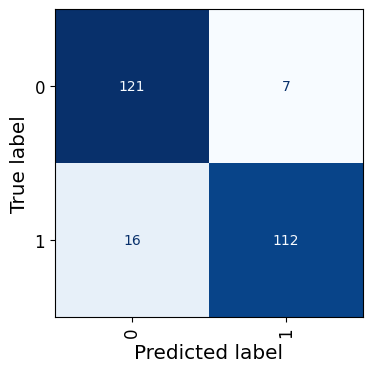

In [66]:
cm  = confusion_matrix(y_test, np.argmax(y_pred, axis = 1))

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1])

fig, ax = plt.subplots(figsize = (4,4))

disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)

plt.show();

In [67]:
hist_df[hist_df['val_loss'] == hist_df['val_loss'].min()]

,loss,accuracy,val_loss,val_accuracy
99,0.312427,0.874023,0.239282,0.910156
